In [43]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from cgeniepy.foram import ForamModel as fm
import numpy as np
import pandas as pd

from cgeniepy.grid import GENIE_lat
import numpy as np

lat = GENIE_lat() * -1
lat_array = np.broadcast_to(lat, (36, 36)).T


mod_paths = ["../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
             "../model/LGM_8P7Z4F_gmd",
             "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
             "../model/pyyyyz.RpCO2_Rp13CO2.2deg.Albani.Foram.Transient",
             "../model/pyyyyz.RpCO2_Rp13CO2.3deg.Albani.Foram.Transient",
             "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
             ]

export_files= ["../data/modern_4pca.csv",
               "../data/lgm_4pca.csv",
               "../data/future1p5_4pca.csv",
               "../data/future2_4pca.csv",
               "../data/future3_4pca.csv",
               "../data/future4_4pca.csv",
               ]

for path, csv_name in zip(mod_paths, export_files):
    mod = fm(path)
    bn = mod.select_foram("bn").relative_abundance().isel(time=-1).array.values.ravel()
    bs = mod.select_foram("bs").relative_abundance().isel(time=-1).array.values.ravel()
    sn = mod.select_foram("sn").relative_abundance().isel(time=-1).array.values.ravel()
    ss = mod.select_foram("ss").relative_abundance().isel(time=-1).array.values.ravel()

    sst = mod.select_var("ocn_sur_temp").isel(time=-1).array.values.ravel()
    sal = mod.select_var("ocn_sur_sal").isel(time=-1).array.values.ravel()
    po4 = mod.select_var("ocn_sur_PO4").isel(time=-1).array.values.ravel()
    prey = mod.select_var("eco2D_Plankton_C_004").isel(time=-1).array.values.ravel()
    fe = mod.select_var("ocn_sur_TDFe").isel(time=-1).array.values.ravel()

    # masked!
    random_var = mod.select_var("ocn_sur_temp").isel(time=-1).array.values
    mask = np.where(np.isnan(random_var), np.nan, 1)
    ## masked lat
    masked_lat = lat_array * mask


    phys_w = mod.select_var("phys_w").isel(time=-1, zt=1).array
    upwelling_discrete = np.where(phys_w >0, 1, 0)

    # temperature gradient between 283 m and 80 m
    therm_gradient = mod.select_var("phys_w").isel(time=-1, zt=3).array - mod.select_var("phys_w").isel(time=-1, zt=1).array

    df = pd.DataFrame({'bn': bn,
                       'bs': bs,
                       'sn':sn,
                       'ss':ss,
                       'sst': sst,
                       #'sal': sal,
                       'po4': po4,
                       'prey': prey,
                       'fe': fe,
                       "lat": masked_lat.ravel(),
                       "upwelling": upwelling_discrete.ravel(),
                       "stratification": therm_gradient.values.ravel()
                       })

    # drop na
    df = df.dropna()
    df = df.query('bn > 0 & bs > 0 & sn > 0 & ss > 0')
    df = df.query('bn < 1 & bs < 1 & sn < 1 & ss < 1')
    df.to_csv(csv_name)

# standardise
#x_scaled = StandardScaler().fit_transform(df)
#pca = PCA(n_components=2)
#pcs = pca.fit(df)

#pcDF = pd.DataFrame(data = pcs,
#                        columns = ['pc1', 'pc2'])
#pcDF = pd.concat([pcDF , pd.DataFrame(target)] , axis = 1)
#import seaborn as sb
#plot = sb.scatterplot(x=pcDF.iloc[:,0], y=pcDF.iloc[:,1], palette='icefire')

ploting bn in ../model/LGM_8P7Z4F_gmd, with threshold in 0.619530588388443
ploting bn in ../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN, with threshold in 0.6278372257947922
ploting bn in ../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient, with threshold in 0.7527627646923065
ploting bs in ../model/LGM_8P7Z4F_gmd, with threshold in 0.3593691289424896
ploting bs in ../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN, with threshold in 0.3194473832845688
ploting bs in ../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient, with threshold in 0.2019086368381977
ploting sn in ../model/LGM_8P7Z4F_gmd, with threshold in 0.1602218970656395
ploting sn in ../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN, with threshold in 0.11702163517475128
ploting sn in ../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient, with threshold in 0.13154719769954681
ploting ss in ../model/LGM_8P7Z4F_gmd, with threshold in 0.6215804368257523
ploting ss in ../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN

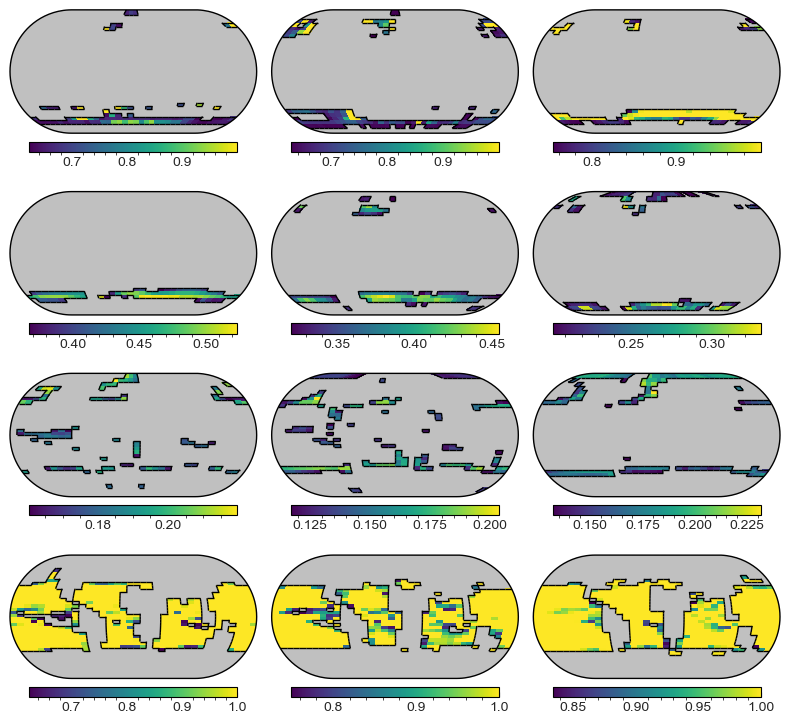

In [46]:
# plot the optimal niche
# question: relative abundance is removing the effects of nutrient availbility
from cgeniepy.foram import ForamModel as fm
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
mod_paths = [
    "../model/LGM_8P7Z4F_gmd",
    "../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]

foram = ["bn", "bs", "sn", "ss"]

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8, 8),
                        subplot_kw={'projection': ccrs.EckertIV()},
                        tight_layout=True)

counter = 0

for j in foram:
    for i in mod_paths:
        data = fm(i).select_foram(j).relative_abundance().isel(time=-1)

        # drop zeros and get 75th percentile
        data_nozero = data.filter(">", 0, overwrite_array=True).filter("<", 1, overwrite_array=True)
        upper_quartile = np.nanpercentile(data_nozero.array, 75)

        # filter data, but read again
        data = fm(i).select_foram(j).relative_abundance().isel(time=-1)
        filtered_data = data.filter(">", upper_quartile, overwrite_array=True)

        # plot
        filtered_data.plot_map(ax = axs.flat[counter], cmap="viridis")
        print(f"ploting {j} in {i}, with threshold in {upper_quartile}")
        counter += 1

fig.savefig("../output/optimal_niche_distribution.jpg", dpi=400)

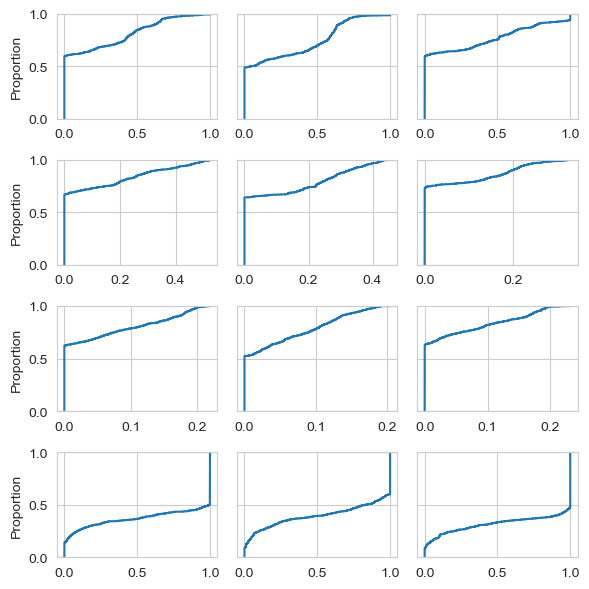

In [47]:
# distribution, ecdf
import seaborn as sns

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(6, 6),
                        tight_layout=True,
                        sharey=True)

foram = ["bn", "bs", "sn", "ss"]
mod_paths = [
    "../model/LGM_8P7Z4F_gmd",
    "../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]


counter = 0

for j in foram:
    for i in mod_paths:
        data = fm(i).select_foram(j).relative_abundance().isel(time=-1)
        sns.ecdfplot(data.array.values.ravel(), ax=axs.flat[counter])
        counter += 1

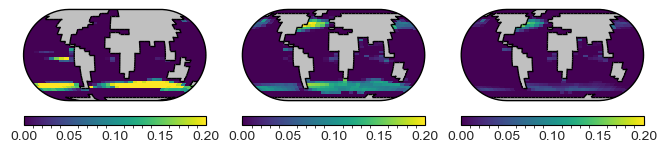

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 5),
                        subplot_kw={'projection': ccrs.EckertIV()})

mod_paths = [
    "../model/LGM_8P7Z4F_gmd",
    "../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN",
    "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
]

counter = 0

for i in mod_paths:
    model = fm(i).select_foram(["bn", "bs","sn","ss"]).biomass(combine_vars=True).take(-1, axis=0)
    model.plot_map(ax=axs.flat[counter], vmax=0.2, cmap="viridis")
    counter += 1

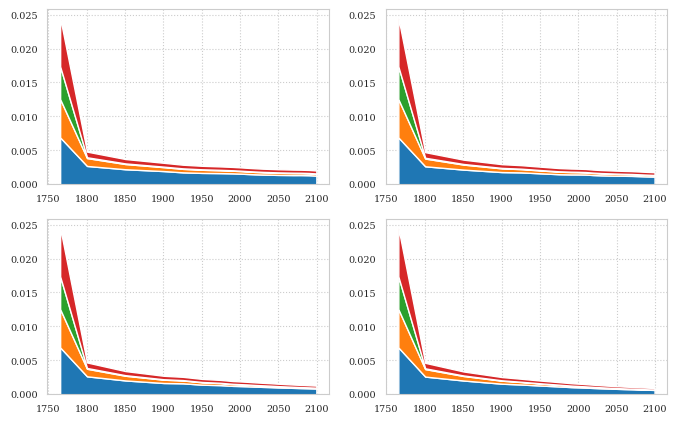

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
mod_paths = [
    "../model/pyyyyz.RpCO2_Rp13CO2.1p5deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.2deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.3deg.Albani.Foram.Transient",
    "../model/pyyyyz.RpCO2_Rp13CO2.4deg.Albani.Foram.Transient",
]

for n, i in enumerate(mod_paths):
    bn, bs, sn, ss = [], [], [], []
    for j in range(20):
        a = fm(i).select_foramtype("bn").biomass().isel(time=j).sum().magnitude
        b = fm(i).select_foramtype("bs").biomass().isel(time=j).sum().magnitude
        c = fm(i).select_foramtype("sn").biomass().isel(time=j).sum().magnitude
        d = fm(i).select_foramtype("ss").biomass().isel(time=j).sum().magnitude

        bn.append(a)
        bs.append(b)
        sn.append(c)
        ss.append(d)
        time = fm(i).select_var("time").array.values
    axs.flat[n].stackplot(time,bn, bs, sn, ss)

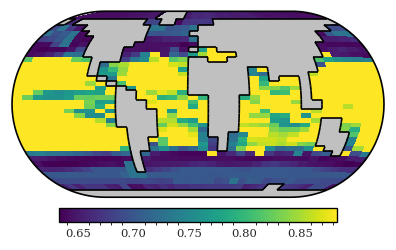

In [7]:
from cgeniepy.foram import ForamModel as fm

x = fm("../model/muffin.CB.worlg4.BASESFeTDTL.FORAM.SPIN").select_foram_community("biomass")
x.dispersion().plot_map()